In [ ]:
import random
from sympy import isprime
from math import gcd
from typing import Tuple


# Function to generate a large prime number
def generate_prime(bits: int) -> int:
    while True:
        prime_candidate = random.getrandbits(bits)
        if isprime(prime_candidate):
            return prime_candidate


# Function to calculate the modular inverse
def modular_inverse(a: int, m: int) -> int:
    m0, x0, x1 = m, 0, 1
    while a > 1:
        q = a // m
        a, m = m, a % m
        x0, x1 = x1 - q * x0, x0
    if x1 < 0:
        x1 += m0
    return x1


# Function to generate RSA key pair
def generate_keypair(bits: int = 1024) -> Tuple[Tuple[int, int], Tuple[int, int]]:
    p = generate_prime(bits // 2)
    q = generate_prime(bits // 2)
    n = p * q
    phi = (p - 1) * (q - 1)

    # Choose e such that 1 < e < phi and gcd(e, phi) = 1
    e = 65537  # Commonly used value for e
    while gcd(e, phi) != 1:
        e = random.randint(2, phi - 1)

    # Calculate d, the modular inverse of e
    d = modular_inverse(e, phi)

    # Public key (e, n), Private key (d, n)
    return (e, n), (d, n)


# Function to encrypt a message
def encrypt(message: str, public_key: Tuple[int, int]) -> int:
    e, n = public_key
    # Convert message to integer
    message_int = int.from_bytes(message.encode('utf-8'), byteorder='big')
    if message_int >= n:
        raise ValueError("Message is too large for the given key size.")
    # Perform encryption
    ciphertext = pow(message_int, e, n)
    return ciphertext


# Function to decrypt a message
def decrypt(ciphertext: int, private_key: Tuple[int, int]) -> str:
    d, n = private_key
    # Perform decryption
    decrypted_int = pow(ciphertext, d, n)
    # Convert decrypted integer back to string
    message = decrypted_int.to_bytes((decrypted_int.bit_length() + 7) // 8, byteorder='big').decode('utf-8')
    return message


# Main driver to test the RSA implementation
if __name__ == "__main__":
    try:
        print("Generating RSA key pair...")
        public_key, private_key = generate_keypair(bits=512)  # Using 512 bits for demonstration

        print(f"Public Key: {public_key}")
        print(f"Private Key: {private_key}")

        message = "assignment2"
        print(f"\nOriginal Message: {message}")

        # Encrypt the message
        ciphertext = encrypt(message, public_key)
        print(f"Encrypted Message (ciphertext): {ciphertext}")

        # Decrypt the message
        decrypted_message = decrypt(ciphertext, private_key)
        print(f"Decrypted Message: {decrypted_message}")

    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"Unexpected Error: {e}")


Generating RSA key pair...
Public Key: (65537, 11620176085997581825267470386199086319221383434841813218168358931580704664439222952244610506277382715209928587837750598231181311178066335601552913425223089)
Private Key: (5089245986181677390339078726445708143805962566645781235044118687354638844979062432166770531995679137142611601855381879974801904604620114622672288318888733, 11620176085997581825267470386199086319221383434841813218168358931580704664439222952244610506277382715209928587837750598231181311178066335601552913425223089)

Original Message: assignment2
Encrypted Message (ciphertext): 11489053396718202753848510325760339517135651905682320861207233949207418776486109685267298330915319328126425054261537362465789980478484054939762425122117246
Decrypted Message: assignment2


1. Potential Vulnerabilities
* Small Key Size: Easily factorized by modern hardware (e.g., 512 bits).
* No Padding Scheme: Vulnerable to CPA and ciphertext replay attacks.
* Message Size Limitation: Large messages exceeding 𝑛 cause errors.
* Weak Randomness: Predictable primes from random.getrandbits().
* Timing Attacks: Decryption leaks processing time information.

2. Mitigation Strategies
* Use larger key sizes (2048+ bits for security, 3072+ for long-term).
* Implement padding schemes (e.g., OAEP) for security against CPA.
* Replace random.getrandbits() with secure random generators like secrets.
* Ensure strong prime generation (e.g., use safe primes).
* Use constant-time algorithms to prevent timing leaks.
* Handle large messages via hybrid encryption (e.g., RSA + symmetric key).
* Deploy blinding techniques to randomize decryption and avoid side-channel leaks.

3. Impact of Key Sizes
* 512 bits: Fast but insecure (easily broken).
* 1024 bits: Weak, short-term use only.
* 2048 bits: Moderate security, good balance of speed and safety.
* 3072 bits: High security, suitable for long-term or sensitive data.
* 4096 bits: Very secure but slower, impractical for performance-critical systems.

4. Potential Side-Channel Attacks
* Timing Attacks: Leak private keys via processing time.
Mitigate with constant-time algorithms.
* Power Analysis: Infer private keys via power usage.
Mitigate with blinding techniques.
* Fault Injection: Exploit faulty computations to derive keys.
Mitigate with error-checking mechanisms.
* Cache Attacks: Infer keys from cache access patterns.
Mitigate with constant-memory access designs.

In [ ]:
!pip install memory-profiler


Generating 1024-bit RSA keys...


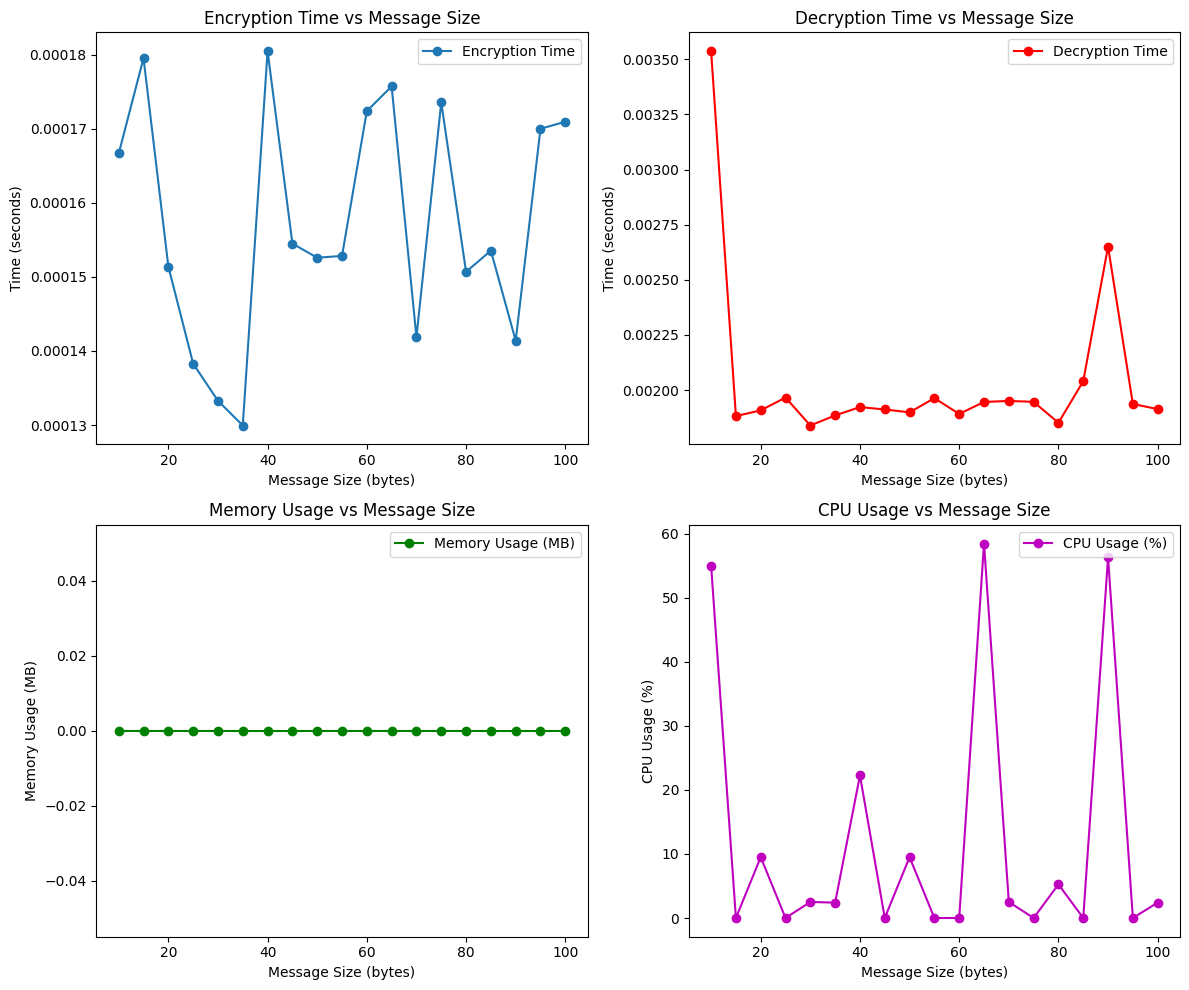

In [ ]:
import time
import psutil
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from rsa import newkeys, encrypt, decrypt

def performance_test(key_size, message_sizes):
    results = {
        "message_size": [],
        "encryption_time": [],
        "decryption_time": [],
        "memory_usage": [],
        "cpu_usage": [],
    }

    print(f"Generating {key_size}-bit RSA keys...")
    public_key, private_key = newkeys(key_size)

    for size in message_sizes:
        message = ("A" * size).encode('utf-8')  # Create a message of the given size

        # Measure encryption
        mem_before = memory_usage(-1, interval=0.1, timeout=1)[0]
        start_time = time.time()
        ciphertext = encrypt(message, public_key)
        encryption_time = time.time() - start_time
        mem_after = memory_usage(-1, interval=0.1, timeout=1)[0]
        cpu_usage_encryption = psutil.cpu_percent(interval=0.1)

        # Measure decryption
        start_time = time.time()
        decrypted_message = decrypt(ciphertext, private_key)
        decryption_time = time.time() - start_time
        cpu_usage_decryption = psutil.cpu_percent(interval=0.1)

        # Store results
        results["message_size"].append(size)
        results["encryption_time"].append(encryption_time)
        results["decryption_time"].append(decryption_time)
        results["memory_usage"].append(mem_after - mem_before)
        results["cpu_usage"].append((cpu_usage_encryption + cpu_usage_decryption) / 2)

    return results

def visualize_results(results):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].plot(results["message_size"], results["encryption_time"], marker='o', label="Encryption Time")
    axs[0, 0].set_title('Encryption Time vs Message Size')
    axs[0, 0].set_xlabel('Message Size (bytes)')
    axs[0, 0].set_ylabel('Time (seconds)')
    axs[0, 0].legend()

    axs[0, 1].plot(results["message_size"], results["decryption_time"], marker='o', label="Decryption Time", color='r')
    axs[0, 1].set_title('Decryption Time vs Message Size')
    axs[0, 1].set_xlabel('Message Size (bytes)')
    axs[0, 1].set_ylabel('Time (seconds)')
    axs[0, 1].legend()

    axs[1, 0].plot(results["message_size"], results["memory_usage"], marker='o', label="Memory Usage (MB)", color='g')
    axs[1, 0].set_title('Memory Usage vs Message Size')
    axs[1, 0].set_xlabel('Message Size (bytes)')
    axs[1, 0].set_ylabel('Memory Usage (MB)')
    axs[1, 0].legend()

    axs[1, 1].plot(results["message_size"], results["cpu_usage"], marker='o', label="CPU Usage (%)", color='m')
    axs[1, 1].set_title('CPU Usage vs Message Size')
    axs[1, 1].set_xlabel('Message Size (bytes)')
    axs[1, 1].set_ylabel('CPU Usage (%)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    key_size = 1024
    message_sizes = [10,15, 20, 25, 30, 35,  40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
    results = performance_test(key_size, message_sizes)
    visualize_results(results)
